In [2]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from astropy.table import Table
from tqdm import tqdm
import pickle, gzip
import multiprocessing
import pandas as pd
from slsim.ImageSimulation.image_simulation import simulate_image, rgb_image_from_image_list
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, append=True)
filterwarnings("ignore", category=RuntimeWarning, append=True)

In [3]:
sky_area = Quantity(200, unit='deg^2')

# load a saved lens population
with gzip.open(f"../data/SLSimLensesNoCuts/SLSIM_GGL_LENSES_{sky_area.value}_SQDEG_0.pkl.gz", "rb") as f:
    selected_lenses = pickle.load(f)

In [13]:
minimal_catalog = {
    'lens_id': [],
    'z_S': [],
    'z_D': [],
    'theta_E_arcsec': [],                # Einstein radius in arcseconds
    'source_radial_distance_arcsec': [], # sqrt(x_S^2 + y_S^2)
    'source_light_R_eff_arcsec': [],
    'es_total_magnification': [],        # mu_total
    'lensed_source_mag_i': [],           # For LSST
    'deflector_mag_i': [],
    'lensed_source_mag_r': [],           
    'deflector_mag_r': [],
    'lensed_source_mag_g': [],
    'deflector_mag_g': [],
    'snr_i': [],
    'contrast_ratio_i_brightest': [],
    'contrast_ratio_i_second_brightest': [],

}

for id, lens in enumerate(tqdm(selected_lenses, desc="Processing lenses for minimal catalog")):
    try:
        lens_id = id
        z_S = lens.source(0).redshift
        z_D = lens.deflector_redshift
        theta_E_arcsec = lens.einstein_radius[0]
        xs, ys = lens.source(0).extended_source_position
        source_radial_distance_arcsec = np.sqrt(xs**2 + ys**2)
        source_light_R_eff_arcsec = lens.source(0).angular_size
        es_total_magnification = lens.extended_source_magnification[0]
        lensed_source_mag_i = lens.extended_source_magnitude(band='i', lensed=True)[0]
        deflector_mag_i = lens.deflector_magnitude(band='i')
        lensed_source_mag_r = lens.extended_source_magnitude(band='r', lensed=True)[0]
        deflector_mag_r = lens.deflector_magnitude(band='r')
        lensed_source_mag_g = lens.extended_source_magnitude(band='g', lensed=True)[0]
        deflector_mag_g = lens.deflector_magnitude(band='g')
        contrast_ratio_i = lens.contrast_ratio(band='i', source_index=0) # this is in mags I_source_light/I_lens_light [mag/arcsec^2]
        contrast_ratio_i = 10**(-contrast_ratio_i / 2.5) # convert to flux ratio # this is an array for each image

        # take contrast ratio of brightest image as representative contrast ratio for the system
        contrast_ratio_i_brightest = np.max(contrast_ratio_i)
        contrast_ratio_i_second_brightest = np.sort(contrast_ratio_i)[-2] if len(contrast_ratio_i) > 1 else 0
    except:
        continue

    

    snr_i = lens.snr(
        band='i',
        fov_arcsec=np.max([theta_E_arcsec * 4, 1]),
        observatory='LSST',
        snr_per_pixel_threshold=1,
    )

    minimal_catalog['lens_id'].append(lens_id)
    minimal_catalog['z_S'].append(z_S)
    minimal_catalog['z_D'].append(z_D)
    minimal_catalog['theta_E_arcsec'].append(theta_E_arcsec)
    minimal_catalog['source_radial_distance_arcsec'].append(source_radial_distance_arcsec)
    minimal_catalog['source_light_R_eff_arcsec'].append(source_light_R_eff_arcsec)
    minimal_catalog['es_total_magnification'].append(es_total_magnification)
    minimal_catalog['lensed_source_mag_i'].append(lensed_source_mag_i)
    minimal_catalog['deflector_mag_i'].append(deflector_mag_i)
    minimal_catalog['lensed_source_mag_r'].append(lensed_source_mag_r)
    minimal_catalog['deflector_mag_r'].append(deflector_mag_r)
    minimal_catalog['lensed_source_mag_g'].append(lensed_source_mag_g)
    minimal_catalog['deflector_mag_g'].append(deflector_mag_g)
    minimal_catalog['snr_i'].append(snr_i)
    minimal_catalog['contrast_ratio_i_brightest'].append(contrast_ratio_i_brightest)
    minimal_catalog['contrast_ratio_i_second_brightest'].append(contrast_ratio_i_second_brightest)
minimal_catalog_table = Table(minimal_catalog)

Processing lenses for minimal catalog: 100%|██████████| 54392/54392 [11:31<00:00, 78.68it/s]


In [33]:
def satisfies_Collett_2015_cuts_table(lens_catalog_table, 
                                      seeing = 0.45, 
                                      snr_threshold_i_band = 20,
                                      contrast_ratio_threshold_i_band = 0.01, # this is in flux ratio (not mags), so 0.01 means the source is 100 times fainter than the lens in the i band
                                      redshift_limit_source = None, 
                                      return_boolean_array = False):
    """
    Checks whether lenses in a given lens catalog table satisfy the Collett 2015 (https://iopscience.iop.org/article/10.1088/0004-637X/811/1/20) cuts.

    Parameters:
    lens_catalog_table: an Astropy Table containing lens properties
    seeing: the seeing in arcseconds (default 0.45 for LSST Optimal Seeing)
    snr_threshold_i_band: the SNR threshold for the i band (default 20 for LSST)
    contrast_ratio_threshold_i_band: the contrast ratio threshold for the i band (default 0.01 for LSST)
    redshift_limit_source: optional redshift limit for the source (default None, meaning no cut)

    Returns:
    A boolean array indicating which lenses satisfy the cuts.
    """
    conditions = np.ones(len(lens_catalog_table), dtype=bool)

    # Criteria 1: Multiple imaging
    condition_1 = lens_catalog_table['source_radial_distance_arcsec'] < lens_catalog_table['theta_E_arcsec']
    conditions &= condition_1

    # Criteria 2: Image Resolution
    condition_2 = lens_catalog_table['theta_E_arcsec'] > np.sqrt(lens_catalog_table['source_light_R_eff_arcsec']**2 + (seeing/2)**2)
    conditions &= condition_2

    # Criteria 3: Tangential Arc Resolution
    condition_3 = lens_catalog_table['es_total_magnification'] * lens_catalog_table['source_light_R_eff_arcsec'] > seeing
    conditions &= condition_3

    # Criteria 4: Magnification
    condition_4 = lens_catalog_table['es_total_magnification'] > 3
    conditions &= condition_4

    # Criteria 5: SNR > 20
    if snr_threshold_i_band is not None:
        snr_i = lens_catalog_table['snr_i'].copy()
        snr_i[snr_i == None] = 0  # Treat None SNR values as 0 for the purpose of this cut
        condition_5 = snr_i > snr_threshold_i_band
        conditions &= condition_5

    # Criteria 6: Contrast Ratio (not in original Collett 2015 cuts, but often used in lens selection)
    # at least two images with contrast ratio > 1 in the i-band
    if contrast_ratio_threshold_i_band is not None:
        condition_6 = (lens_catalog_table['contrast_ratio_i_brightest']*lens_catalog_table['es_total_magnification'] > contrast_ratio_threshold_i_band)
        condition_6 &= (lens_catalog_table['contrast_ratio_i_second_brightest']*lens_catalog_table['es_total_magnification'] > contrast_ratio_threshold_i_band)
        conditions &= condition_6
    
    # Criteria 6: Redshift cuts for Source if needed (e.g. for 4MOST)
    if redshift_limit_source is not None:
        condition_6 = lens_catalog_table['z_S'] < redshift_limit_source
        conditions &= condition_6

    if return_boolean_array:
        return conditions
    else:
        return lens_catalog_table[conditions]

In [44]:
#collett cuts 
collett_cuts_catalog_LSST_Y10 = satisfies_Collett_2015_cuts_table(minimal_catalog_table, 
                                                                  seeing=0.77, 
                                                                  snr_threshold_i_band=20, 
                                                                  contrast_ratio_threshold_i_band=None)
# collett_cuts_catalog_LSST_Y10 = collett_cuts_catalog_LSST_Y10[collett_cuts_catalog_LSST_Y10['theta_E_arcsec'] > 0.5]
print(f"Number of lenses (20K deg^2) satisfying Collett 2015 cuts: {len(collett_cuts_catalog_LSST_Y10)*20000/sky_area.value}")

Number of lenses (20K deg^2) satisfying Collett 2015 cuts: 62500.0


In [54]:
collett_cuts_catalog_LSST_Y10.colnames

['lens_id',
 'z_S',
 'z_D',
 'theta_E_arcsec',
 'source_radial_distance_arcsec',
 'source_light_R_eff_arcsec',
 'es_total_magnification',
 'lensed_source_mag_i',
 'deflector_mag_i',
 'lensed_source_mag_r',
 'deflector_mag_r',
 'lensed_source_mag_g',
 'deflector_mag_g',
 'snr_i',
 'contrast_ratio_i_brightest',
 'contrast_ratio_i_second_brightest']

In [60]:
import numpy as np

# Step 1: Filter for "Discoverable" Lenses first
# We use seeing=0.2 to approximate the "Union" of LSST (ground) and Euclid/Roman (space).
# If a lens isn't resolvable/detectable by imaging, 4MOST won't target it.
discovery_indices = satisfies_Collett_2015_cuts_table(
    minimal_catalog_table, 
    seeing=0.20,              # Excellent seeing (Space-based proxy for Union)
    snr_threshold_i_band=20,  # Standard detection threshold
    contrast_ratio_threshold_i_band=None, # No contrast ratio cut for discovery
    return_boolean_array=True
)

discovered_pool = minimal_catalog_table[discovery_indices]

# 2. Define the "Targetable" Pool (Source is bright enough for Redshift)
# 4MOST requires Source R_mag < 24.0 and z < 1.5
mask_targetable = (discovered_pool['lensed_source_mag_r'] < 24.0) & \
                  (discovered_pool['z_S'] < 1.5)

targetable_candidates = discovered_pool[mask_targetable]

# 3. Sort candidates by Deflector Brightness (Brightest first)
# We use 'argsort' on the Deflector R-band magnitude
sorted_indices = np.argsort(targetable_candidates['deflector_mag_r'])
ranked_candidates = targetable_candidates[sorted_indices]

# 4. Calculate the Scaling Factor
# We need to know how many simulated lenses = 1 full survey lens
# e.g., if you simulated 200 deg2, and survey is 20,000 deg2, factor is 100.
scaling_factor = 20000 / sky_area.value 

# 5. Select the "Top N" based on the Survey Budget
# We want 10,000 real lenses. If factor is 100, we need 10000/100 = 100 simulated lenses.
n_wanted_spec = int(10000 / scaling_factor)
n_wanted_kinematics = int(5000 / scaling_factor)

# Slice the ranked arrays
sample_4most_spec_10k = ranked_candidates[:n_wanted_spec]
sample_4most_kinematics_5k = ranked_candidates[:n_wanted_kinematics]

# --- Verification ---
print(f"Targetable Pool (Total): {len(targetable_candidates) * scaling_factor:.0f}")
print(f"Selected 4MOST Spec Sample: {len(sample_4most_spec_10k) * scaling_factor:.0f}")
print(f"Selected 4MOST Kinematics Sample: {len(sample_4most_kinematics_5k) * scaling_factor:.0f}")

# Check the resulting magnitude limit (The 'Effective' Cut)
effective_mag_cut = np.max(sample_4most_kinematics_5k['deflector_mag_r'])
print(f"Effective Deflector Cut for 5k Sample: r < {effective_mag_cut:.2f}")

Targetable Pool (Total): 55300
Selected 4MOST Spec Sample: 10000
Selected 4MOST Kinematics Sample: 5000
Effective Deflector Cut for 5k Sample: r < 18.04


In [ ]:

collett_selected_lenses = []
for lens, is_selected in zip(selected_lenses, sorted_indices):
    if is_selected:
        collett_selected_lenses.append(lens)

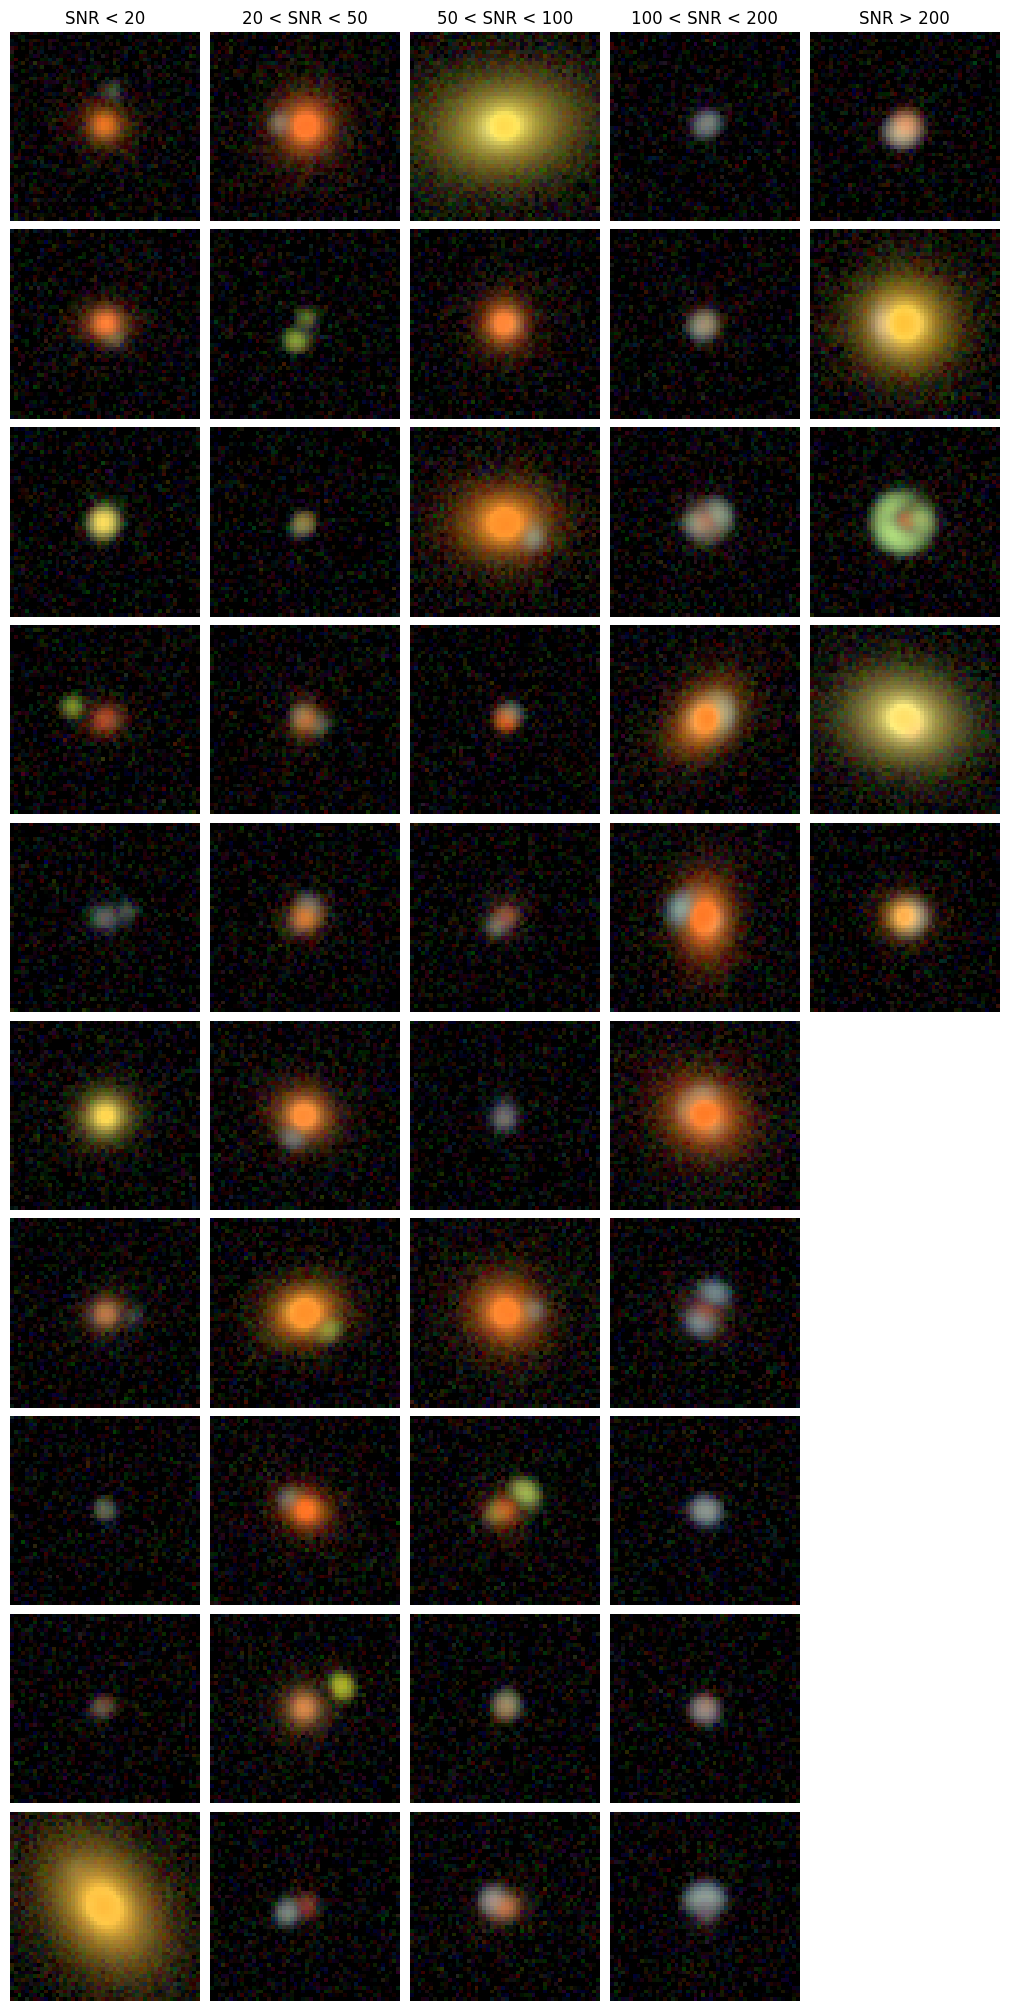

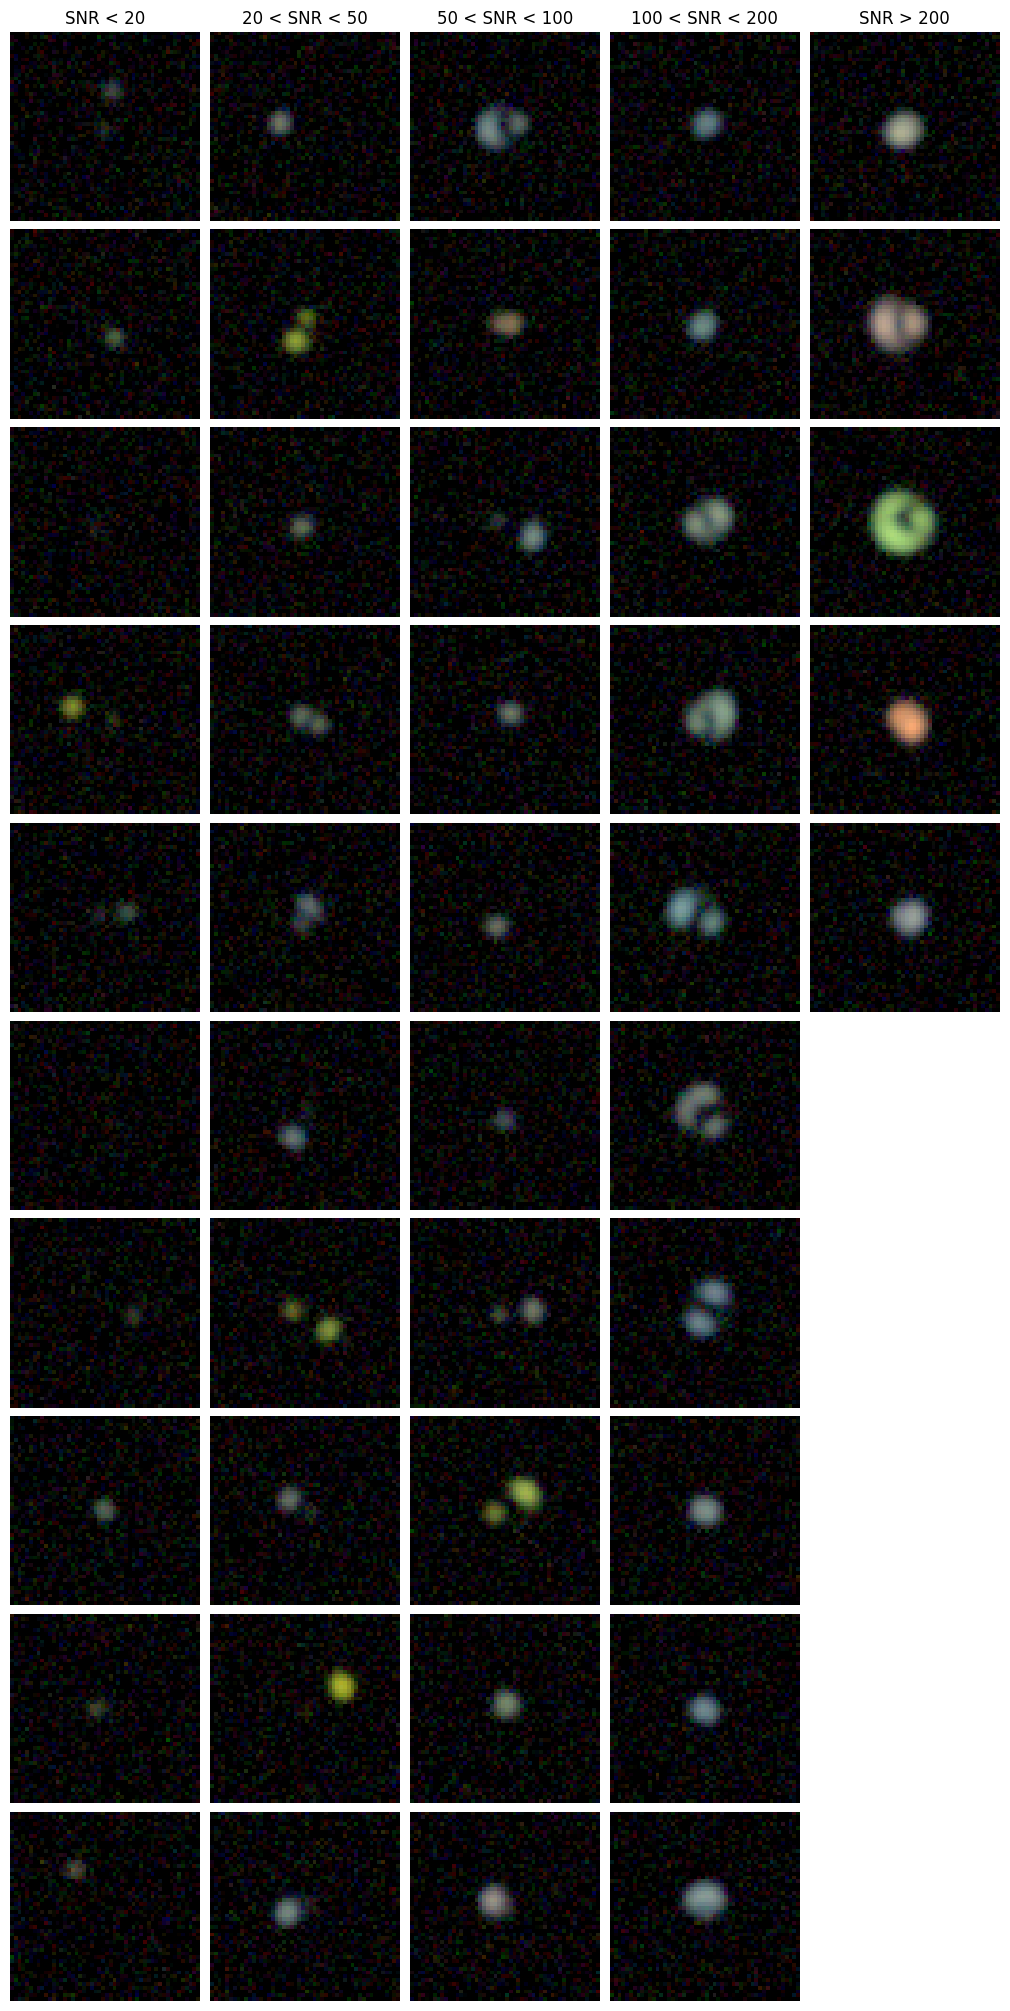

In [65]:
# Define SNR bins: (lower_bound, upper_bound, title)
snr_bins = [
    (None, 20, "SNR < 20"),
    (20, 50, "20 < SNR < 50"),
    (50, 100, "50 < SNR < 100"),
    (100, 200, "100 < SNR < 200"),
    (200, None, "SNR > 200"),
]
buckets = {i: [] for i in range(len(snr_bins))}
buckets_no_deflector = {i: [] for i in range(len(snr_bins))}  # For images without deflector light

for gg_lens in collett_selected_lenses[:200]:  # Limit to first 200 lenses for visualization
    theta_e = gg_lens.einstein_radius[0]
    snr = gg_lens.snr(
        band="g",
        fov_arcsec=np.max([theta_e * 4, 1]),  # 4 times Einstein radius, or at least 1"
        observatory="LSST",
        snr_per_pixel_threshold=1,
    )

    rgb_image = []
    rgb_image_no_deflector = []
    for band in ['i', 'r', 'g']:
        image = simulate_image(
            lens_class=gg_lens,
            band=band,
            observatory="LSST",
            add_noise=True,
            num_pix=50,
            with_source=True,
            with_deflector=True,
            with_point_source=True,
        )
        rgb_image.append(image)
        image_no_deflector = simulate_image(
            lens_class=gg_lens,
            band=band,
            observatory="LSST",
            add_noise=True,
            num_pix=50,
            with_source=True,
            with_deflector=False,  # No deflector light
            with_point_source=True,
        )
        rgb_image_no_deflector.append(image_no_deflector)
    image = rgb_image_from_image_list(rgb_image, stretch=1)
    image_no_deflector = rgb_image_from_image_list(rgb_image_no_deflector, stretch=1)

    # Assign image to appropriate bucket
    for idx, (low, high, _) in enumerate(snr_bins):
        if snr is None and low is None:
            buckets[idx].append(image)
            buckets_no_deflector[idx].append(image_no_deflector)
            break
        elif snr is not None:
            if (low is None or snr >= low) and (high is None or snr < high):
                buckets[idx].append(image)
                buckets_no_deflector[idx].append(image_no_deflector)
                break

# Plot results
n_rows = 10
_, ax = plt.subplots(n_rows, len(snr_bins), figsize=(10, 20), constrained_layout=True)

for col, (_, _, title) in enumerate(snr_bins):
    ax[0, col].set_title(title)
    for row in range(n_rows):
        ax[row, col].axis("off")
        if row < len(buckets[col]):
            ax[row, col].imshow(buckets[col][row], origin="lower", cmap="viridis")


plt.show()

# No deflector light
n_rows = 10
_, ax = plt.subplots(n_rows, len(snr_bins), figsize=(10, 20), constrained_layout=True)

for col, (_, _, title) in enumerate(snr_bins):
    ax[0, col].set_title(title)
    for row in range(n_rows):
        ax[row, col].axis("off")
        if row < len(buckets_no_deflector[col]):
            ax[row, col].imshow(buckets_no_deflector[col][row], origin="lower", cmap="viridis")

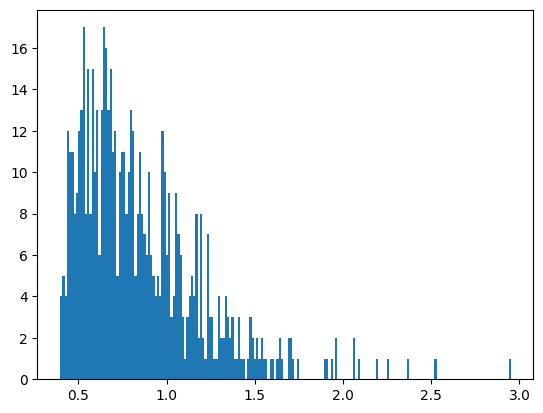

In [165]:
plt.hist(collett_cuts_catalog_LSST_Y10['theta_E_arcsec'], bins=200);
# plt.xlim(0, 500);

In [138]:
len(collett_cuts_catalog_LSST_Y10[
    # (collett_cuts_catalog_LSST_Y10['lensed_source_mag_i'] < 24) &
    (collett_cuts_catalog_LSST_Y10['deflector_mag_i'] < 24) &
    (collett_cuts_catalog_LSST_Y10['z_S'] < 1.5)])*20000/sky_area.value

np.float64(9900.0)

In [125]:
collett_cuts_catalog_LSST_Y1 = collett_cuts_catalog_LSST_Y10.copy()
# sort by SNR and choose the top sqrt(1/10) fraction to simulate Y1 cuts
collett_cuts_catalog_LSST_Y1.sort('snr_i')
num_lenses_Y1 = int(len(collett_cuts_catalog_LSST_Y10) * np.sqrt(1/10))
collett_cuts_catalog_LSST_Y1 = collett_cuts_catalog_LSST_Y1[-num_lenses_Y1:]
print(f"Number of lenses (20K deg^2) satisfying Collett 2015 cuts for Y1: {len(collett_cuts_catalog_LSST_Y1)*20000/sky_area.value}")

Number of lenses (20K deg^2) satisfying Collett 2015 cuts for Y1: 35500.0


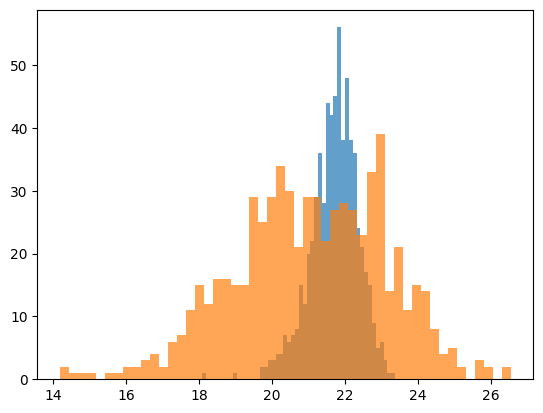

In [123]:
plt.hist(collett_cuts_catalog_LSST_Y10['lensed_source_mag_i'], bins=50, alpha=0.7);
plt.hist(collett_cuts_catalog_LSST_Y10['deflector_mag_i'], bins=50, alpha=0.7);

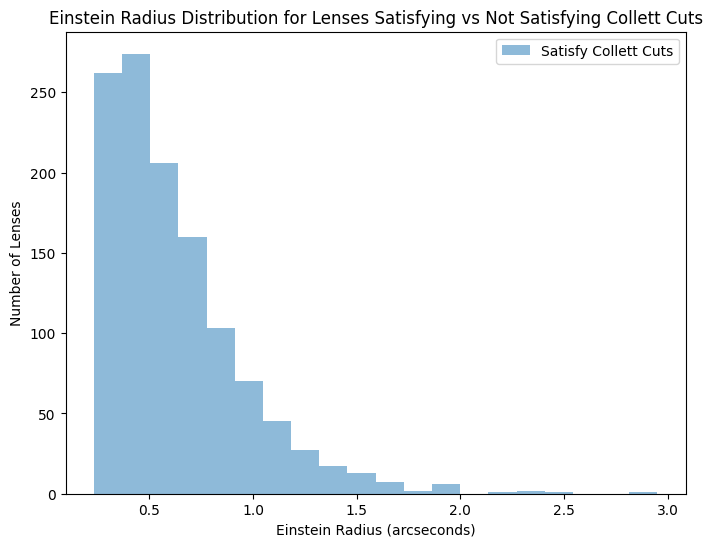

In [96]:
# plot einstein radius histogram for lenses that satisfy Collett cuts vs those that don't
plt.figure(figsize=(8,6))
plt.hist(collett_cuts_catalog_LSST_Y10['theta_E_arcsec'], bins=20, alpha=0.5, label='Satisfy Collett Cuts')
plt.xlabel('Einstein Radius (arcseconds)')
plt.ylabel('Number of Lenses')
plt.title('Einstein Radius Distribution for Lenses Satisfying vs Not Satisfying Collett Cuts')
plt.legend()

Text(1, 0.5, 'Collett 2015 Cuts:\n\nSNR > SNR threshold\n$\\sqrt{x_S^2 + y_S^2} < \\theta_E$\n$\\theta_E > \\sqrt{R_{\\rm eff, src}^2 + ({\\rm seeing}/2)^2}$\n$\\mu_{\\rm total} R_{\\rm eff, src} > {\\rm seeing}$\n$\\mu_{\\rm total} > 3$')

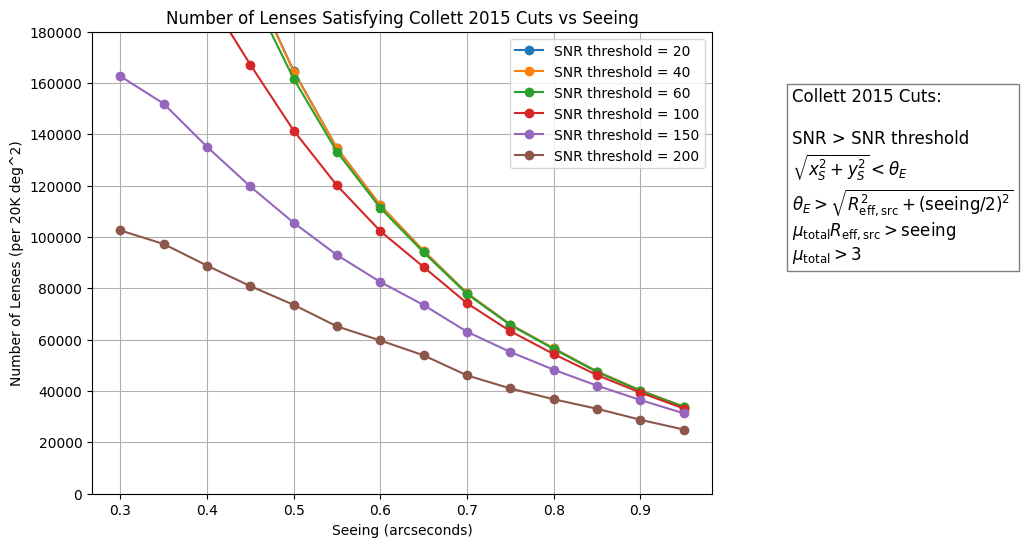

In [117]:
# plot as a function of seeing 
plt.figure(figsize=(8,6))

seeing_vals = np.arange(0.3, 1.0, 0.05)
for SNR_threshold in [20, 40, 60, 100, 150, 200]:
    num_lenses_vals = []
    for seeing in seeing_vals:
        cuts_catalog = satisfies_Collett_2015_cuts_table(minimal_catalog_table, 
                                                        seeing=seeing, 
                                                        snr_threshold_i_band=SNR_threshold)
        num_lenses_vals.append(len(cuts_catalog)*20000/sky_area.value)

    plt.plot(seeing_vals, num_lenses_vals, marker='o', label=f'SNR threshold = {SNR_threshold}')
plt.xlabel('Seeing (arcseconds)')
plt.ylabel('Number of Lenses (per 20K deg^2)')
plt.title('Number of Lenses Satisfying Collett 2015 Cuts vs Seeing')
plt.ylim(0, 180000)
plt.grid()
plt.legend()

### Add text next to the plot that shows cuts used in Collett 2015 in LATEX format
textstr = '\n'.join((
    r'Collett 2015 Cuts:'+'\n',
    # r'$0.5 < \theta_E < 4$ arcsec',
    r'SNR > SNR threshold',
    r'$\sqrt{x_S^2 + y_S^2} < \theta_E$',
    r'$\theta_E > \sqrt{R_{\rm eff, src}^2 + ({\rm seeing}/2)^2}$',
    r'$\mu_{\rm total} R_{\rm eff, src} > {\rm seeing}$',
    r'$\mu_{\rm total} > 3$',
))
plt.gcf().text(1, 0.5, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
